# Time series forecasting with DeepAR - Synthetic data

DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Boto3를 사용하면 Python 애플리케이션, 라이브러리 또는 스크립트를 Amazon S3, Amazon EC2, Amazon DynamoDB 등 AWS 서비스와 쉽게 통합할 수 있습니다
import boto3
import sagemaker

# get_execution_role : 초기에 설정해 뒀던 IAM role 가져오기
# IAM 역할 : AWS에서 자격증명할때 필요함

from sagemaker import get_execution_role

np.random.seed(1)

Let's start by specifying:
- The S3 bucket prefix that you want to use for training and model data. Here we use the default bucket with `sagemaker_session.default_bucket()`, but you can change this to a bucket of your choosing. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [2]:
prefix = "sagemaker/DEMO-deepar"

# 방문자가 웹 서버에 접속해 있는 상태를 하나의 단위로 보고 그것을 세션이라고 한다.

sagemaker_session = sagemaker.Session()

role = get_execution_role() # IAM 자격증명 가져옴

bucket = sagemaker_session.default_bucket() # S3 Bucket

s3_data_path = f"{bucket}/{prefix}/data" # S3 Bucket 데이터 경로 설정 
s3_output_path = f"{bucket}/{prefix}/output"

Next, we configure the container image to be used for the region that we are running in.

# 훈련 작업 생성 및 실행

내장 Amazon SageMaker 알고리즘은 Amazon Elastic Container Registry(Amazon ECR)에 Docker 컨테이너로 저장됩니다. 모델을 훈련시키려면 먼저 Amazon ECR에서 해당 리전에 가장 가까운 forecasting-deepa 컨테이너 위치를 지정해야 합니다.

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# 이미지 가져오기
image_uri = get_image_uri(boto3.Session().region_name, "forecasting-deepar")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


### Generating and uploading data

In this example we want to train a model that can predict the next 48 points of syntheticly generated time series.
The time series that we use have hourly granularity.

In [4]:
freq = "H" # hour 시간을 의미한다. 시간으로 설정한다. 1시간 기준이다.

# 48시간 이후 예측 할 수 있는 모델을 훈련시킬 것이다.
prediction_length = 48 # The prediction_length is fixed when a model is trained and it cannot be changed later

We also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In our example we will use a longer `context_length` of `72`. Note that in addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

context_length	파라미터 이름 

네트워크가 어느 시점까지 볼 수 있는지 결정합니다. HPO 프로세스는 다음에 대한 값을 자동으로 설정합니다.context_length모델 정확도를 극대화하는 동시에 훈련 시간을 고려합니다.

context_length 하이퍼파라미터는 과거 네트워크에서 확인 가능한 거리를 제어하며, prediction_length 하이퍼파라미터는 향후 예상할 수 있는 범위를 제어합니다.
과거 72일 데이터셋 패턴으로 예측하기 위해 아래와 같이 변수 설정함

In [5]:
context_length = 72

For this notebook, we will generate 200 noisy time series, each consisting of 400 data points and with seasonality of 24 hours. In our dummy example, all time series start at the same time point `t0`. When preparing your data, it is important to use the correct start point for each time series, because the model uses the time-point as a frame of reference, which enables it to learn e.g. that weekdays behave differently from weekends.

In [6]:
t0 = "2016-01-01 00:00:00"# 시작시간
data_length = 400 #데이터 행 수
num_ts = 200 # noisy time 설정
period = 24 # 24시간

Each time series will be a noisy sine wave with a random level. 

> noise 처리

>> 노이즈(noise)라고도 불리는 이 데이터는 추세, 계절성 등으로 설명되지 않은 데이터를 의미한다. 이러한 데이터를 가지고 예측하게 된다면 예측의 오차가 커지기 때문에 전처리를 통해서 최대한 예측하는데 관여하지 않도록 하는 것이 중요하다.
랜덤함수 적용 시켜준다. 추세라는 것은 말 그대로 경향을 의미한다. 세부적인 데이터를 다 빼고 전체적으로 보았을 때 주식이 감소하는지 증가하는지 대략적인 정보를 보여준다. 계절성(Seasonality)은 특정한 기간마다 어떤 패턴을 가지고 반복하는지 확인 할 수 있는 특성이다. 이 데이터를 통해 앞으로 어떻게 변화할 것인지 예측할 수 있다.
실제 데이터에는 노이즈를 잘 찾아 적용시켜주어야한다. 밑에 함수는 임의적인 노이즈 데이터를 적용시켜 주었다. 

In [7]:
time_series = []
# num_ts = 200 # noisy time 설정 / 위에서 설정해준값 200 범위에서 k값 나오게 for문 돌림
for k in range(num_ts):  
    level = 10 * np.random.rand() # 0~1 사이의 값을 10을 곱해 지면서 1~10 사이의 값들이 만들어 집니다.
    seas_amplitude = (0.1 + 0.3 * np.random.rand()) * level # y 축 값들을 2.5 ~ 6.0 으로 설정함
    sig = 0.05 * level  # noise parameter (constant in time)  
    time_ticks = np.array(range(data_length)) # 배열로 만듬
    
    source = level + seas_amplitude * np.sin(time_ticks * (2 * np.pi) / period) # 시그모이드 함수 적용
    noise = sig * np.random.randn(data_length) # 임의적으로 노이즈를 만들어줍니다,
    data = source + noise # 실제 데이터에는 노이즈가 포함된다. 임의적으로 적용시켜주었습니다. 
    
    # 위에서 설정해준 변수 t0 (시작값), freq 변수 시간으로 정한 값을 적용시켜줍니다.
    index = pd.date_range(start=t0, freq=freq, periods=data_length)
    
    time_series.append(pd.Series(data=data, index=index)) # 시계열 데이터는 series 를 적용시켜 줌

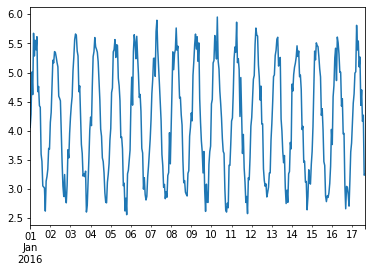

In [118]:
time_series[0].plot()
plt.show()

Often one is interested in tuning or evaluating the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

In this example, we will leave out the last section of each of the time series we just generated and use only the first part as training data. Here we will predict 48 data points, therefore we take out the trailing 48 points from each time series to define the training set. The test set contains the full range of each time series.

In [9]:
time_series_training = [] # 훈련데이터 리스트 만들어줌
for ts in time_series:
    time_series_training.append(ts[:-prediction_length]) # 48시간 이후 예측 할 수 있는 모델을 훈련 시키기 위해 48시간 전까지 훈련데이터로 만들어 준다.

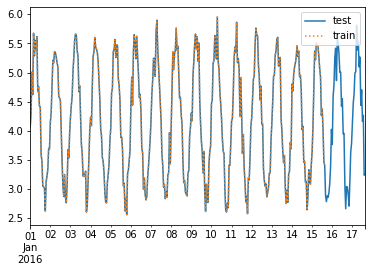

In [10]:
time_series[0].plot(label="test") # 테스트 데이터 시각화
time_series_training[0].plot(label="train", ls=":") # .... 으로 훈련데이터 시각화 해줌
plt.legend()
plt.show()

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

# DeepAR preprocessing

 > DeepAR supports two types of data files: JSON Lines (one JSON object per line) and Parquet.

- start : A string with the format YYYY-MM-DD HH:MM:SS

- target : An array of floating-point values or integers that represent the time series. You can encode missing values as null literals, or as “NaN” strings in JSON,

- cat(선택 사항) : An array of categorical features that can be used to encode the groups that the record belongs to. Categorical features must be encoded as a 0-based sequence of positive integers. For example, the categorical domain {R, G, B} can be encoded as {0, 1, 2}. All values from each categorical domain must be represented in the training dataset. That's because the DeepAR algorithm can forecast only for categories that have been observed during training.
 

## DeepAR 알고리즘을 사용하기 위해 JSON 형식으로 만들어 줄 수 있는 함수 생성

- JSON 


1. XML, YAML 과 함께 효율적으로 데이터를 저장하고 교환하는데 사용하는 텍스트 데이터 포맷

2. 구조 

  2.1 이름/값 쌍의 집합 (A collection of name/value pairs): object, record, struct, dictionary, hash table, keyed list, associative array
  
  2.2 정렬된 값의 리스트 (An ordered list of values): array, vector, list, sequence


    

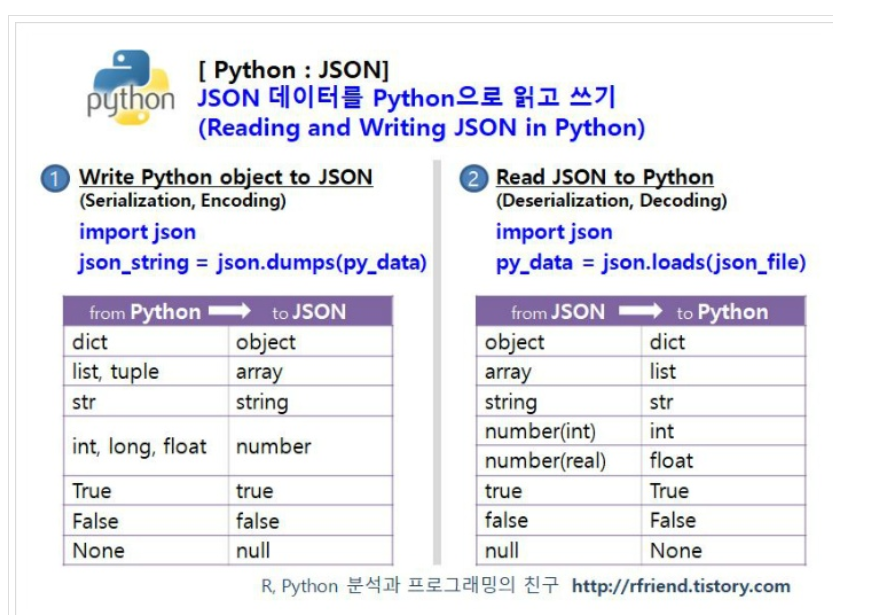

"https://ai-example.notebook.ap-northeast-2.sagemaker.aws/view/amazon-sagemaker-examples/synthetic_data/data/20220222_185322_1.png"

In [11]:
def series_to_obj(ts, cat=None):
    ''' 
    obj 변수는 dict으로 구성되어 있다. python object를 json으로 변환시키기 위해 
    json.dumps 함수 적용시킴  
    '''
    obj = {"start": str(ts.index[0]), "target": list(ts)} # start는 string 이여야 함, ts는 데이터를 담은 변수이다.
    if cat is not None: # cat default 값이 None인데 None 이 아닐때 실행됨
        obj["cat"] = cat
    return obj

# json 형태로 반환 할 수 있는 함수
def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

** client **

1. low-level 인터페이스

2. service description에 의해 만들어짐

3. botocore 수준의 client를 공개(botocore는 AWS CLI와 boto3의 기초가 되는 라이브러리)

4. AWS API와 1:1 매핑됨
    
5. 메소드가 스네이크 케이스로 정의되어 있음

In [12]:
encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"

# 훈련데이터 json 형태로 저장
# 바이너리 파일형태로 써주고 저장한다.
with open(FILE_TRAIN, "wb") as f:
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding)) #json 형태로 반환 할 수 있는 함수 적용/ encode 적용 
        f.write("\n".encode(encoding))

# 테스트데이터 json 형태로 저장
with open(FILE_TEST, "wb") as f:
    for ts in time_series:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

# AWS s3인 버킷에 파일 업로드 함        
s3 = boto3.client("s3")

# prefix = "sagemaker/DEMO-deepar" 위에서 경로 설정한거 변수 넣어줌
s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)

### Train a model

We can now define the estimator that will launch the training job.

In [13]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="DEMO-deepar",
    output_path=f"s3://{s3_output_path}",
)

Next we need to set some hyperparameters: for example, frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as number of epochs, batch size, and learning rate. Refer to the documentation for a full description of the available parameters.

In [14]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

In [15]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [16]:
data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

estimator.fit(inputs=data_channels)

2022-02-22 04:57:05 Starting - Starting the training job...
2022-02-22 04:57:32 Starting - Preparing the instances for trainingProfilerReport-1645505825: InProgress
......
2022-02-22 04:58:33 Downloading - Downloading input data...
2022-02-22 04:59:03 Training - Downloading the training image......
2022-02-22 05:00:03 Training - Training image download completed. Training in progress.Arguments: train
[02/22/2022 04:59:59 INFO 140467533358464 integration.py:592] worker started
[02/22/2022 04:59:59 INFO 140467533358464] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 

### Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note:** remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [17]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

-------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [18]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

In [19]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [20]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series[:5]

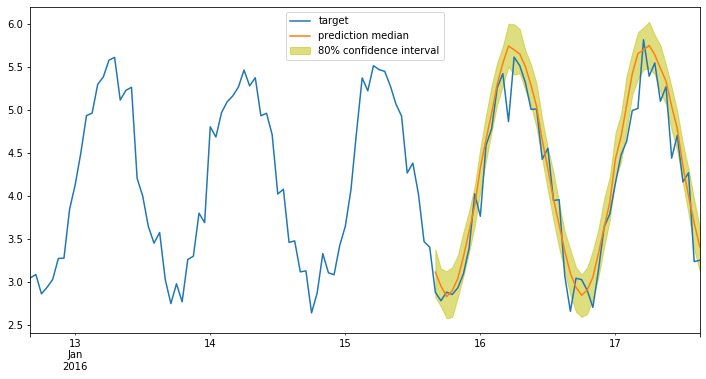

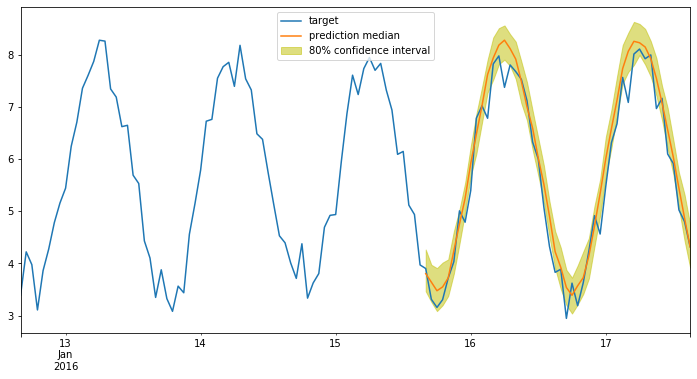

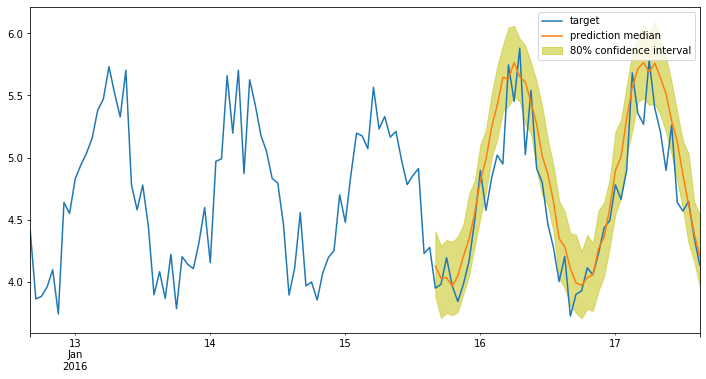

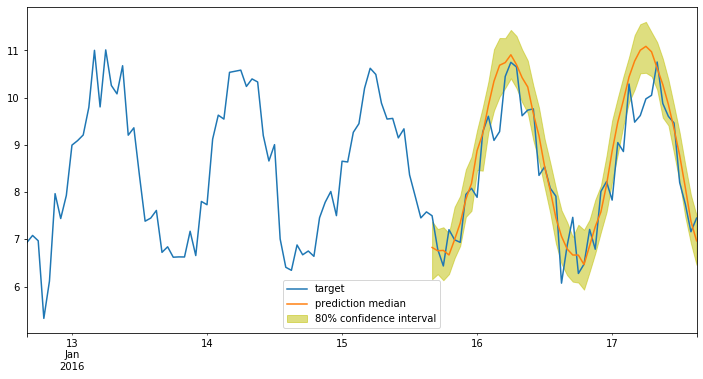

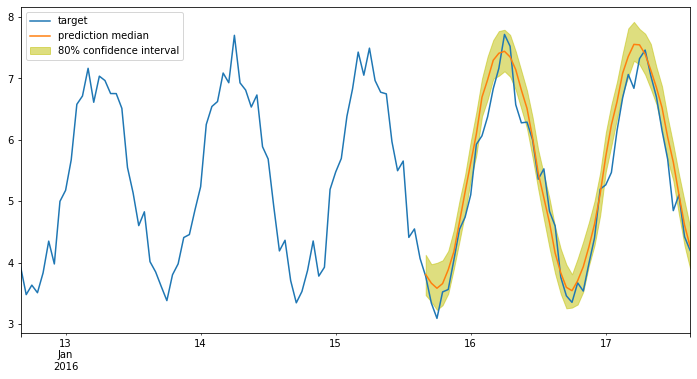

In [21]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

### Delete endpoint

In [ ]:
sagemaker_session.delete_endpoint(endpoint_name)